In [2]:
!pip3 install --user opencv-python

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import cv2
from itertools import product

## Input Files

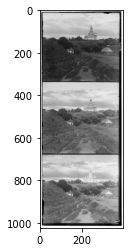

In [4]:
input_file = 'data/cathedral.jpg'
im = cv2.imread(input_file, cv2.IMREAD_GRAYSCALE)
plt.imshow(im, cmap=plt.get_cmap('gray'))

In [5]:
print(im.shape)
im_num_rows = im.shape[0]
im_num_co1s = im.shape[1]

(1024, 390)


### Helper Functions

In [6]:
def display_result(B_start, G_start, R_start, channel_height, channel_width):
    # create channel matricies
    B_mat = im[B_start[0]:B_start[0]+channel_height, B_start[1]:B_start[1]+channel_width]
    G_mat = im[G_start[0]:G_start[0]+channel_height, G_start[1]:G_start[1]+channel_width]
    R_mat = im[R_start[0]:R_start[0]+channel_height, R_start[1]:R_start[1]+channel_width]
    
    result = cv2.merge((B_mat, G_mat, R_mat))
    plt.imshow(result)

# Aligning Channels

In [26]:
# returns a sub_matrix extracted from IM
def sub_image(im, start, h, w, r_offset=0, c_offset=0):
    # initialize result to have 'inf' as padding
    result = np.full((h - 2*r_offset, w - 2*c_offset), np.inf)
    # extract sub_matrix from IM
    a = im[start[0]+r_offset : start[0]+h-r_offset, start[1]+c_offset : start[1]+w-c_offset]
    result[:a.shape[0], :a.shape[1]] = a
    return result

### Alignment Algorithms

#### 1. Basic

In [27]:
# return alignment index by simply dividing the image in 3
def align_basic(im):
    num_rows = im.shape[0]
    B_start = [0,0]
    G_start = [num_rows//3,0] # floor division to get integer indices
    R_start = [num_rows//3*2,0]
    height = im.shape[0]//3
    width = im.shape[1]
    return B_start, G_start, R_start, height, width

#### 2. SSD

In [41]:
# Returns 
def ssd(a, b):
    return sum((a - b)**2)

# Returns the displacement vector that gives best result
def align_ssd(im, h, w, disp_interval):
    score = {}
    b_start = (0, 0)
    o_start = (h, 0)
    print(disp_interval)
    for d in range(disp_interval[0], disp_interval[1]):
        b_channel = sub_image(im, b_start, h, w, r_offset=0, c_offset=0)
        other = sub_image(im, o_start, h, w, r_offset=0, c_offset=0)
        score[d] = ssd(b_channel, other)
    #print(score)
    return min(score)

## Adjustments

In [42]:
# normalize exposures
# takes in a matrix with values within [1,0], 
# and transforms it so that the minimum value becomes 0, maximum value becomes 1
def fix_exposure(mat):
    unit_len = np.amax(mat) - np.amin(mat)
    mat = (mat - np.amin(mat))/unit_len

In [43]:
def adjust(B_mat, G_mat, R_mat):
    fix_exposure(B_mat)
    fix_exposure(G_mat)
    fix_exposure(R_mat)

# Display Results

[0, 0] [341, 0] [682, 0]
341 390


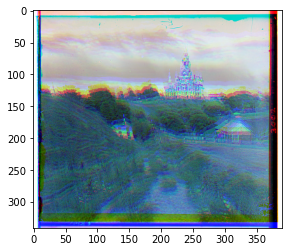

In [44]:
B_start, G_start, R_start, channel_height, channel_width = basic(im)
print(B_start, G_start, R_start)
print(channel_height, channel_width)
display_result(B_start, G_start, R_start, channel_height, channel_width)

[326, 356]
[667, 697]
(0, 0) (326, 0) (667, 0)


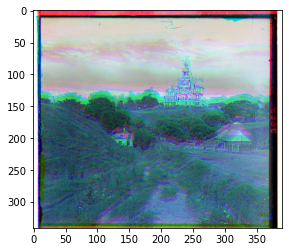

In [45]:
h, w = im.shape[0]//3, im.shape[1]
B_start = (0,0)
G_start = (align_ssd(im, h, w, [h - 15, h + 15]), 0)
R_start = (align_ssd(im, h, w, [h * 2 - 15, h * 2 + 15]), 0)
print(B_start, G_start, R_start)
display_result(B_start, G_start, R_start, channel_height, channel_width)